FORCAST Grism Spectra: Custom Spectral Extraction
================
* **Aim**: Extract grism data with a user-defined aperture. <br />
* **Data**: Level 3 grism data of the Saturn Nebula (G111)<br />
* **Tools**: astropy, DS9 <br />
* **Instrument**: FORCAST<br />
* **Documentation**: [FORCAST data handbook](https://www.sofia.usra.edu/sites/default/files/USpot_DCS_DPS/Documents/FORCAST_data_handbook.pdf)
* **Notebook repository**: https://github.com/SOFIAObservatory/Recipes

Goals
---------
* Inspect previous aperture extraction
* Determine optimal new extraction based on 2D spectral image
* Plot newly extracted spectrum

## Introduction

This recipe provides an overview and sample code (in Python) for custom spectral extractions from the LEVEL_2 2-D rectified images produced by the FORCAST pipeline.  We recommend that the user reviews the first FORCAST Grism Recipe ([FORCAST Grism Recipe: Basic Inspection and Assessment](FORCAST-Grism_Inspection.ipynb)) before proceeding with this slightly more advanced tutorial.  

Raw FORCAST data suffers from several instrumental artifacts.  Nearly all of the artifacts are removed or corrected by the FORCAST pipeline, including: bad pixels; the Droop effect; non-linear pixel response; and the “jailbar” effect.  In addition, the grism pipeline extracts the one-dimensional spectra, applies both wavelength and flux calibration, and corrects for telluric absorption.   For point sources, an "optimal extraction" algorithm is used, while for extended (non-pointlike) sources, a standard summation over a manually defined aperture is used.  See the [FORCAST GO Data Handbook](https://www.sofia.usra.edu/sites/default/files/USpot_DCS_DPS/Documents/FORCAST_data_handbook.pdf) for details regarding the artifacts, pipeline algorithms, and the flux-calibration process.  

The extraction aperture for extended sources is generally set manually to include all the flux from the source and may not be exactly what the guest investigator (GI) needs for his or her science.  For our purposes the extraction aperture is simply the "window" in slit position [x_lo,x_hi] over which flux is summed at each wavelength to produce a 1-D spectrum (flux vs wavelength).  The final extracted 1-D spectrum is saved in a CAL file as usual (see [FORCAST Grism Recipe: Basic Inspection and Assessment](FORCAST-Grism_Inspection.ipynb) for review); in addition, the pipeline saves the wavelength-calibrated, recitifeid 2-D spectral image (from which the extraction is made) in a corresponding RIM file, with wavelength along the x-axis and slit position along the y-axis.  

In this recipe we show the user how to plot the aperture used on the 2-D spectral image and how to do a simple custom extraction using a different aperture if desired.  If a custom extraction is needed, we strongly encourage the GI to contact the [SOFIA Help Desk](mailto:sofia_help@sofia.usra.edu) and request re-reduction with the specifed aperture(s).  This ensures that the GI gets the best quality data using the latest pipeline routines.

## Imports

In [1]:
from astropy.io import fits
from astropy.table import Table, Column
from astropy import constants as const
from astropy import units as u
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from aplpy import FITSFigure
import numpy as np
%matplotlib inline

## Ingredients

1. Level 3 (flux calibrated) FORCAST grism data (either CAL or CMB files) from the Infrared Science Archive ([IRSA](https://irsa.ipac.caltech.edu/Missions/sofia.html)) and the accompanying LEVEL_2 RIM file(s) for each CAL or CMB file.
    - You can obtain the RIM files for a given AOR by using the following search criteria:
        - Processing State: Level 2
    - The accompanying RIM files will have the same name as the CAL/CMB files, except with "RIM" in the middle of the name instead of "CAL"/"CMB" (see example below).  
2.  Sample Data (if desired):  In this example we will be using observations of the PN NGC 7009.  
    - Level 3 data can be obtained from the IRSA using the following search criteria:
        - Coordinates or Object Name = NGC 7009
        - Radius = 100 arcseconds
        - Mission ID = "2017-08-07_FO_F428"
        - AOR ID = 05_0063_7
        - Instrument = FORCAST
        - Processing State = Level 3
    - Download all data and save to local desktop.       
    - To get the LEVEL_2 RIM files use the exact same search along with:
        - Processing State = "Level 2"
      And again download all the data and save to local desktop.  
    - For this example we will be using the following files:  
        - F0428_FO_GRI_0500637_FORG111_CAL_0177-0196.fits
        - F0428_FO_GRI_0500637_FORG111_RIM_0177-0196.fits
    - For convenience, we recommend saving in a folder called "forcast-sample-data" in the same directory as this Python Notebook.

#### You can download the example data directly [here](https://zenodo.org/record/5706312/files/FORCAST-Grism_Inspection-example-data.zip?download=1).

3. [FORCAST GO Handbook](https://www.sofia.usra.edu/sites/default/files/USpot_DCS_DPS/Documents/FORCAST_data_handbook.pdf) for reference (latest version can be found on the [SOFIA Data Products](https://www.sofia.usra.edu/data/data-processing-0#DataHandbooks) page.)
4. Download and install [APLpy](https://aplpy.github.io/). 

## Inspecting the Extraction Aperture

Our first task is to determine what aperture was used with the default pipeline extraction and plot it on the 2-D rectified image for evaluation.  First load the CAL and RIM files and plot the extracted spectrum from the CAL file:

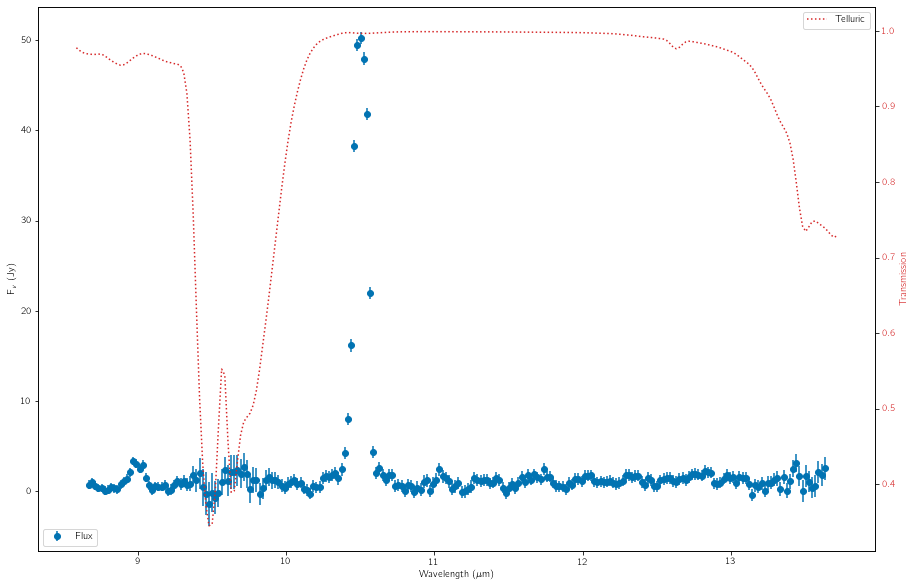

In [2]:
#Define a function for loading fits data into tables with units
def loadFORCASTGrismData(filename):
    #Now open fits file for the sample data...
    data_fits = fits.open(filename)

    #... read the data portion of the file into a separate array:
    data_tmp = data_fits[0].data

    #... load into table for convenience
    data_table = Table([data_tmp[0],data_tmp[1],data_tmp[2],data_tmp[3],data_tmp[4]], 
                  names=('wavelength', 'flux', 'error', 'telluric', 'response'), masked = True,
                  meta={'name': 'Data Table'})

    #and assign units.
    data_table['wavelength'].unit = 'micron'
    data_table['flux'].unit = 'Jy'
    data_table['error'].unit = 'Jy'
    data_table['response'].unit = 'Jy/s'
    
    return data_fits,data_table


#Calibrated data file on local disk:
calfile = 'example_data/FORCAST/F0428_FO_GRI_0500637_FORG111_CAL_0177-0196.fits'

#Load FITS data and tabular data...
g111_fits, g111_tab=loadFORCASTGrismData(calfile)

#And plot flux and telluric spectra
fig, ax1 = plt.subplots(figsize=(15,10))

ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_ylabel('F$_v$ (Jy)')
ax1.errorbar(g111_tab['wavelength'],g111_tab['flux'],yerr=g111_tab['error'],fmt='o',label="Flux")
ax1.legend(loc="lower left")

color = 'tab:red'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Transmission', color=color)
ax2.plot(g111_tab['wavelength'],g111_tab['telluric'], color=color, linestyle=':',label="Telluric")
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend();

Now suppose we want to take a look at the 2-D spectral image from which this extraction was made.  The recitified 2-D images are stored in the LEVEL_2 "RIM" file ("F0428_FO_GRI_0500637_FORG111_RIM_0177-0196.fits").  The easiest way to quickly read and display this file is to use AplPy (remember that FORCAST image data is stored in 3-D data "cubes" where the first plane is flux):

INFO: Auto-setting vmin to -4.069e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.674e-02 [aplpy.core]


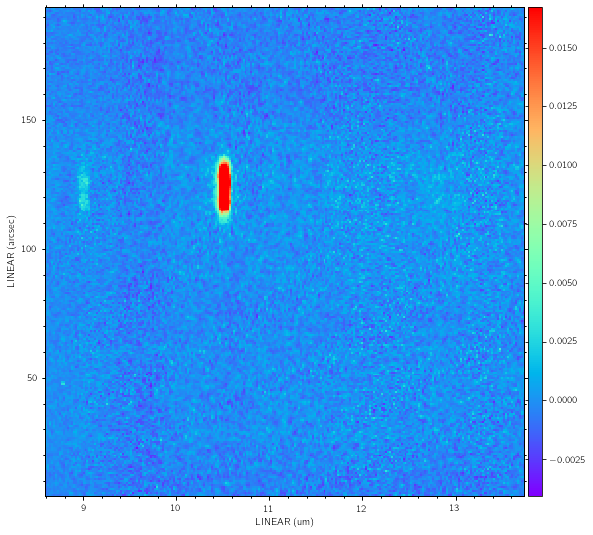

In [3]:
#Load RIM file...
rimfile = 'example_data/FORCAST/F0428_FO_GRI_0500637_FORG111_RIM_0177-0196.fits'
g111rim_fits = fits.open(rimfile)

#And now display 2-d image from RIM file
cmap = 'rainbow'
axs = FITSFigure(g111rim_fits, slices = [0]) #0-th slice contains flux
axs.show_colorscale(cmap=cmap)
axs.add_colorbar();

AplPy automatically applies the coordinate transformation matrix (CD matrix) stored in the FITS header to the data, which will make the next step (aperture display) a little easier.  So here you can see there appears to be a strong line around 10.6 $\mu$m and a weaker one at 9 $\mu$m.  Since this is clearly not a resolved point source, the user might want to know what aperture was used for the 1-d extraction.  The aperture position and radius is stored in the *CAL* file header using the FITS keywords "APPOSO01" and "APRADO01" in units of *arcsec*, so lets grab those values and display them:

In [4]:
#Find apertures for G111 extraction, [position (arcsec),radius (arcsec)]
g111_ap = [float(g111_fits[0].header['APPOSO01']),
           float(g111_fits[0].header['APRADO01'])]
print,g111_ap;

So the aperture used for the extraction was centered at 120 arcsec with a radius of +/- 20 arcsec, which we can now plot on teh 2-D rectified image:

INFO: Auto-setting vmin to -3.920e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.317e-02 [aplpy.core]


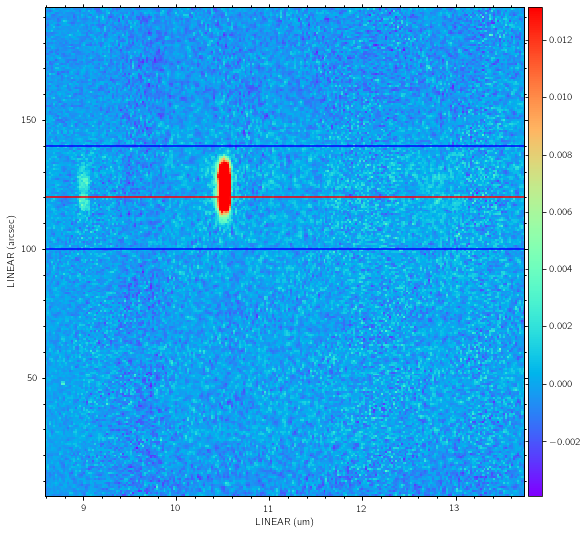

In [5]:
#Display the image again
cmap = 'rainbow'
axs = FITSFigure(g111rim_fits, slices = [0])
axs.show_colorscale(cmap=cmap)
axs.add_colorbar()

cent=g111_ap[0]
rad=g111_ap[1]

#Define center line, and low/hi limits using simple numpy array: [[x1, x2],[y1,y2]]
ap_cent = np.array([[8, 14],[cent,cent]])
ap_lo = np.array([[8, 14],[cent-rad,cent-rad]])
ap_hi = np.array([[8, 14],[cent+rad,cent+rad]])

#and now use matplotlib.showlines to overplot the lines on the 2-D image.
axs.show_lines([ap_cent], color = 'r')
axs.show_lines([ap_lo], color = 'b')
axs.show_lines([ap_hi], color = 'b');

## Custom Extractions

To make a custom extraction, the user will need the original CAL (or CMB) file (for the telluric and response spectra), the corresponding RIM file, and the size and location of the desired aperture(s). In the example above, the aperture used appears to be a little large and slightly misaligned.  We recommend that the user first explore the RIM file using a separate image analysis tool like DS9 in order to identify the exact location and size of the desired apertures.  In the case above, using DS9, we see that the spectral line at ~10.5 $\mu$m is double-peaked in the spatial direction:

![2-D Image](figs/ds9_image.png)

We can also plot flux as a function of slit position for a vertical line-cut along the emission line (see orange line above):

![Line Plot](figs/ds9_plot.png)

The spatial separation of the two peaks is approximately 10 pixels, which corresponds to ~7.7 arcsec. Since the FWHM of the PSF at 11 $\mu$m is typically <3.0 arcsec, this indicates that the two peaks are likely to be real (which might be excpected for a planetary nebula) and we might want to extract spectra for each separately in order to compare the line flux from each position. Using DS9, we estimate the approximate locations and widths of each new aperture (1 and 2) *in pixel space*:
-   Aperture 1
    - Center:  162
    - Width: 16
- Aperture 2
    - Center: 147
    - Width: 11

NOTE:  Normally we would also identify additional background regions for subtraction.  Since the RIM file has already been sky-subtracted, the background is very close to zero and should not make a huge difference in the results of this "quick" extraction.

We will need to first extract the image array from the RIM file.  Remember that the RIM data is a data *cube* containing flux (0), variance (1), and coverage (2).  We only need the flux array for this exercise:

In [6]:
#Read the data portion of the file into a separate array for convenience.
tmp = g111rim_fits[0].data
g111_rim = tmp[0,:,:]  #0th plane contains the flux.

Now define our apertures and plot them on the RIM image.

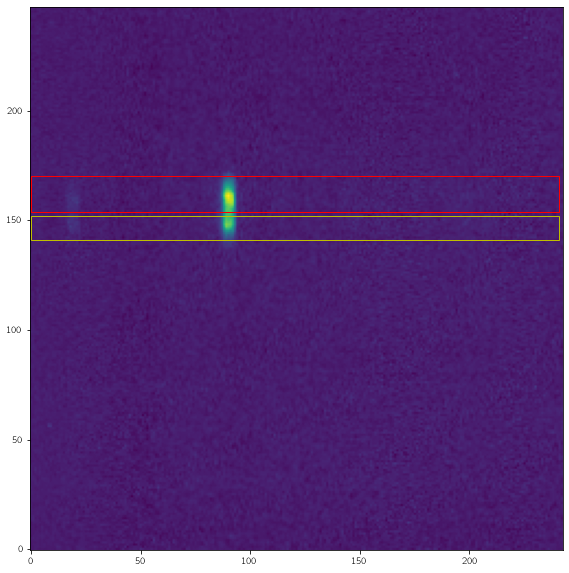

In [7]:
#original aperture from pipeline reduction as reference.
#ap0_cent = 150
#ap0_width = 50 

#Define new apertures:
ap1_cent = 162
ap1_width = 16
ap2_cent = 147
ap2_width = 11

#and convert to integer arrays:
ap1 = np.array([ap1_cent-0.5*ap1_width,ap1_cent+0.5*ap1_width],dtype='int_')
ap2 = np.array([ap2_cent-0.5*ap2_width,ap2_cent+0.5*ap2_width],dtype='int_')

# Create figure and axes
fig,ax = plt.subplots(1,figsize=(15,10))

# Display the RIM image
ax.imshow(g111_rim,origin='lower')

# Create a rectangle patch for each aperture:
ap1_patch = patches.Rectangle((0,ap1[0]),241,ap1_width,
                             linewidth=1,edgecolor='r',facecolor='none')
ap2_patch = patches.Rectangle((0,ap2[0]),241,ap2_width,
                             linewidth=1,edgecolor='y',facecolor='none')

# Add the patches
ax.add_patch(ap1_patch)
ax.add_patch(ap2_patch)

plt.show()

Since the 2-D RIM file is already wavelength rectified and calibrated, all we need to do is sum the data in each aperture over the spatial dimension to get the flux at each wavelength in the *wavelength array stored in the CAL file*.  In order to flux calibrate, simply divide by the telluric and response sepctra provided in the CAL file that we loaded earlier in the recipe.  Note, however, that for Nod-Match-Chop mode (NMC) the central (positive) source is *doubled* after stacking, so a factor of 0.5 must be applied to account for this doubling.  Most grism observations with FORCAST are taken in NMC mode, but you can confirm by checking the FITS keyword "SKYMODE".

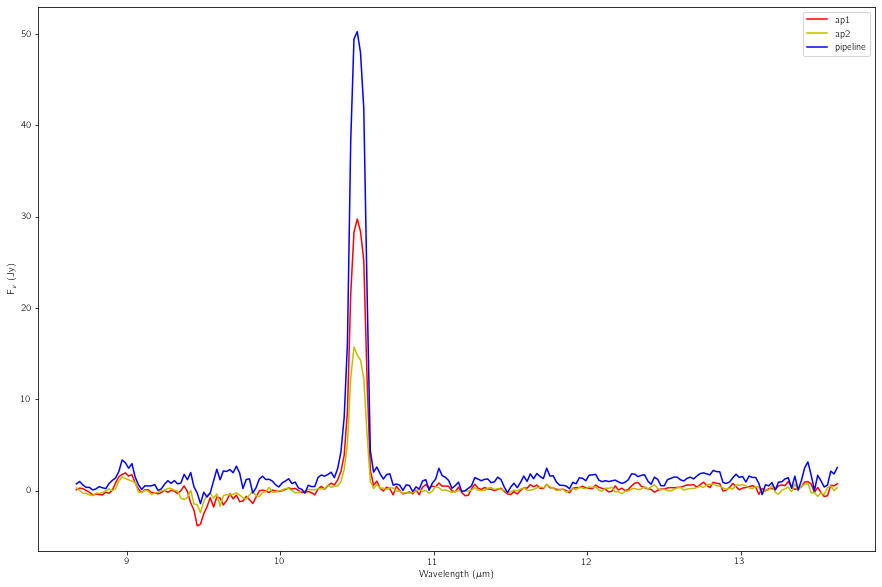

In [8]:
#Sum RIM data over spatial dimension of each aperture,
#and apply telluric correction and response function to flux calibrate.
flux1 = np.sum(g111_rim[ap1[0]:ap1[1],:242],axis=0) / g111_tab['telluric'] / g111_tab['response']
flux2 = np.sum(g111_rim[ap2[0]:ap2[1],:242],axis=0) / g111_tab['telluric'] / g111_tab['response']

#If FITS keyword "SKYMODE" =  "NMC", divide by 2 to account for doubled up central beam.
if g111_fits[0].header['SKYMODE'] == 'NMC': 
    flux1 = 0.5*flux1
    flux2 = 0.5*flux2

#Since the wavelength solution in the CAL file is *derived* from the RIM file,
#we can simply plot the resulting flux arrays for each aperture against the wavelength array 
#in the CAL file.
plt.figure(figsize=(15,10))
plt.plot(g111_tab['wavelength'], flux1, label='ap1', color='r')
plt.plot(g111_tab['wavelength'], flux2, label='ap2', color='y')
#and plot the default pipeline output for comparison.
plt.plot(g111_tab['wavelength'], g111_tab['flux'], label='pipeline', color='b')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('F$_v$ (Jy)')
plt.legend();

We can see from this simple double aperture extraction that the lineflux in the "upper" part of the PN (aperture 1) is about twice that in the "lower" part (aperture 2).  This quick extraction method is a good way to explore the data and decide whether a re-reduction should be requested from the SOFIA Science Center.  If the user finds that a re-extraction with different aperture(s) is warranted by this quick-look method, we encourage him or her to contact the [SOFIA Help Desk](mailto:sofia_help@sofia.usra.edu) with a re-reduction request. 